<a href="https://colab.research.google.com/github/Griff-Kaiga/facial-detection-model/blob/main/Facial_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Moraan, mostly we run models using jupyter notebook or colab(like this one). To run this, click on connect, clickon the runtime tab, seleect restart and run all option and you good to go.

In [ ]:
# importing the neccesary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
 
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation, Dense
from keras.layers import Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
 
data_dir = "/content/drive/MyDrive/humans"
data_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
data_paths = [i for i in data_paths if os.path.isfile(i)]

In [ ]:
# loading the images off disk and defining some parameters for it
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# creating a training and validation test set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split= 0.2,
    subset= 'training',
    seed= 123,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    
    labels = 'inferred'
)

print(train_ds.class_names)

Found 11222 files belonging to 3 classes.
Using 8978 files for training.
['cats', 'dogs', 'persons']


In [ ]:
# validation dataset
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed= 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 11222 files belonging to 3 classes.
Using 2244 files for validation.


In [ ]:
# configuring the dataset for performace
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# standardizing my data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9739714


In [ ]:
# model creation
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
# compile it
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# get the summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [ ]:
# fitting in the training data
epochs=10
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/10
281/281 [==============================] - 864s 3s/step - loss: 0.8444 - accuracy: 0.5933 - val_loss: 0.5113 - val_accuracy: 0.7389
Epoch 2/10
281/281 [==============================] - 272s 969ms/step - loss: 0.3945 - accuracy: 0.8246 - val_loss: 0.3960 - val_accuracy: 0.8249
Epoch 3/10
281/281 [==============================] - 271s 966ms/step - loss: 0.2627 - accuracy: 0.8912 - val_loss: 0.3370 - val_accuracy: 0.8565
Epoch 4/10
281/281 [==============================] - 272s 968ms/step - loss: 0.1844 - accuracy: 0.9216 - val_loss: 0.3457 - val_accuracy: 0.8543
Epoch 5/10
281/281 [==============================] - 271s 964ms/step - loss: 0.1226 - accuracy: 0.9537 - val_loss: 0.4758 - val_accuracy: 0.8547
Epoch 6/10
281/281 [==============================] - 270s 962ms/step - loss: 0.0805 - accuracy: 0.9689 - val_loss: 0.5555 - val_accuracy: 0.8137
Epoch 7/10
281/281 [==============================] - 274s 975ms/step - loss: 0.0603 - accuracy: 0.9797 - val_loss: 0.5770 - va

In [ ]:
# performing data augmentation to allow for generalization
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

NameError: ignored

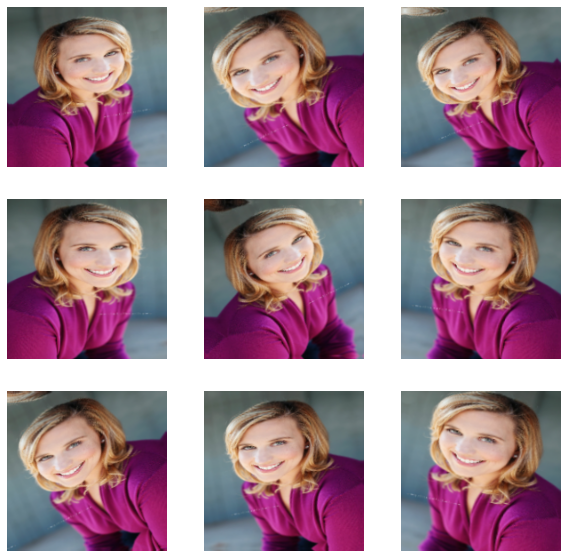

In [ ]:
# visualizing a few augmentated examples
index = 1
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(index):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# introducing dropout layer to prevent overfitting
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# get the summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
# training the model
epochs = 10
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/10
281/281 [==============================] - 318s 1s/step - loss: 0.8102 - accuracy: 0.6320 - val_loss: 0.5155 - val_accuracy: 0.7678
Epoch 2/10
281/281 [==============================] - 310s 1s/step - loss: 0.5115 - accuracy: 0.7782 - val_loss: 0.4325 - val_accuracy: 0.8102
Epoch 3/10
281/281 [==============================] - 320s 1s/step - loss: 0.4543 - accuracy: 0.8070 - val_loss: 0.4563 - val_accuracy: 0.8066
Epoch 4/10
281/281 [==============================] - 311s 1s/step - loss: 0.4159 - accuracy: 0.8229 - val_loss: 0.4857 - val_accuracy: 0.8097
Epoch 5/10
281/281 [==============================] - 311s 1s/step - loss: 0.3865 - accuracy: 0.8379 - val_loss: 0.4059 - val_accuracy: 0.8222
Epoch 6/10
281/281 [==============================] - 310s 1s/step - loss: 0.3590 - accuracy: 0.8521 - val_loss: 0.4330 - val_accuracy: 0.8195
Epoch 7/10
281/281 [==============================] - 309s 1s/step - loss: 0.3347 - accuracy: 0.8531 - val_loss: 0.3917 - val_accuracy: 0.8378

In [ ]:
# evaluate the model using the test dataset
model.evaluate(valid_ds)[1]

71/71 [==============================] - 19s 268ms/step - loss: 0.3428 - accuracy: 0.8596


0.8596256971359253

This is the point where you test your model using a photo. run the first cell below and click on the file to upload, assuming you have the photo on your machine. 
 

In [ ]:
# test the model with an example
from google.colab import files
uploaded_file = files.upload()

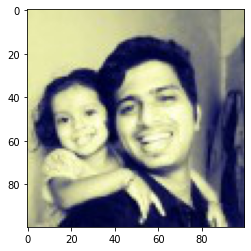

In [ ]:
# preview the image
new_image = plt.imread('632316-gp.jpg')
test_image = plt.imshow(new_image)

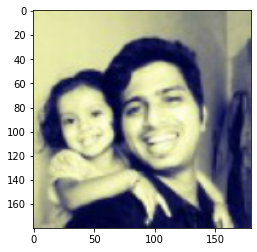

In [ ]:
# resize the image 
from skimage.transform import resize
resized_image = resize(new_image, (180,180,3))

# show the resized image
image = plt.imshow(resized_image)

In [ ]:
resized_image.shape
# models prediction
predictions =model.predict(np.array([resized_image]))

# showing the predictions
predictions



array([[ 4.1743703, -1.0280274, -1.0846623]], dtype=float32)

In [ ]:
# sort the predictions from the least to greatest
list_index = [0,1,2]
x = predictions

for i in range(2):
  for j in range(2):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

# show sorted labels in order
print(list_index)

[0, 1, 2]
